## Large Policy v2

Given unknown `(s, a, r, sp)` data, find optimal policy. Not all `(s, a)` pairs will be seen in data, so interpolate from neighbors.
- States: |S| = 302020
- Actions: 9 actions
- Discount factor = 0.95

Lisa Fung

Last Updated: 11/9/24

### Data Exploration

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [2]:
large_data = pd.read_csv("./data/large.csv")

In [129]:
n_states = 302020
n_actions = 9

In [3]:
large_data.head()
print("Unique rewards:", sorted(large_data['r'].unique()))
print(f"Data contains {len(large_data['s'].unique())} unique states s")
print(f"Data contains {len(large_data['sp'].unique())} unique states sp")
# print("Unique states:", large_data['s'].unique())
print()
print("State, action pairs:")
print(large_data[['s', 'a']].value_counts().sort_index(level=[0, 1]))
print()
# print("Data of finishing states (reached flag):")
# print(large_data[large_data['r'] > 100000 - 250].hist())

Unique rewards: [np.int64(-10), np.int64(-5), np.int64(0), np.int64(5), np.int64(10), np.int64(50), np.int64(100)]
Data contains 500 unique states s
Data contains 500 unique states sp

State, action pairs:
s       a
150101  1    6
        2    7
        3    7
        4    5
        5    3
            ..
302020  4    6
        5    5
        6    3
        7    6
        8    8
Name: count, Length: 4498, dtype: int64



In [106]:
print("Reward distribution:\n", large_data['r'].value_counts().sort_index(level=0))
print("Rewards:", np.sort(large_data['r'].unique()))
print()
for r in np.sort(large_data['r'].unique()):
    if r != 0:
        print(f"States s with reward = {r}:", np.sort(large_data[large_data['r'] == r]['s'].unique()))
        print()
# print("States s with reward = 50:", np.sort(large_data[large_data['r'] == 50]['s'].unique()))

print("(s, a) with r = 100:")
print(large_data[large_data['r'] == 100][['s', 'a']].value_counts().sort_index(level=[0,1]))

Reward distribution:
 r
-10        86
-5        364
 0      98457
 5        417
 10       398
 50        95
 100      183
Name: count, dtype: int64
Rewards: [-10  -5   0   5  10  50 100]

States s with reward = -10: [301012 301111 301113 301212]

States s with reward = -5: [150310 150404 150411 151010 231314 231413 231420 232014 271110 271204
 271211 271310 290410 291004 291011 291110]

States s with reward = 5: [150313 150412 150414 151013 230213 230312 230314 230413 271114 271213
 271220 271314 290203 290302 290304 290403]

States s with reward = 10: [151103 151202 151204 151303 230302 230401 230403 231002 271112 271211
 271213 271312 291112 291211 291213 291312]

States s with reward = 50: [300110 300204 300211 300310]

States s with reward = 100: [300413 301011 301012 301014 301110 301112 301113 301211]

(s, a) with r = 100:
s       a
300413  2     1
        3     1
        4    15
301011  2     1
        3     2
        4    15
301012  1    23
301014  1     2
        2    29
     

In [52]:
# Specific (s, a) transitions
print("Reward = 100 when end up at states:", large_data[large_data['r'] == 100]['sp'].value_counts().index.values)

# large_data[large_data['sp'] == 301111][['s', 'a', 'r']].value_counts().sort_index()

# R=100
# delta_s = sp-s
# Go to sp = 301013 via action a=[1,4]
    # s=300413, a=4 (delta_s = +600)
    # s=301012, a=1 (delta_s = +1)
    # s=301014, a=2 (delta_s = -1)
    # s=301113, a=3 (delta_s = -100)
# Go to sp = 301111 via action a=[1,4]
    # s=301011, a=4 (delta_s = +100)
    # s=301110, a=1 (delta_s = +1)
    # s=301112, a=2 (delta_s = -1)
    # s=301211, a=3 (delta_s = -100)

Reward = 100 when end up at states: [301111 301013]


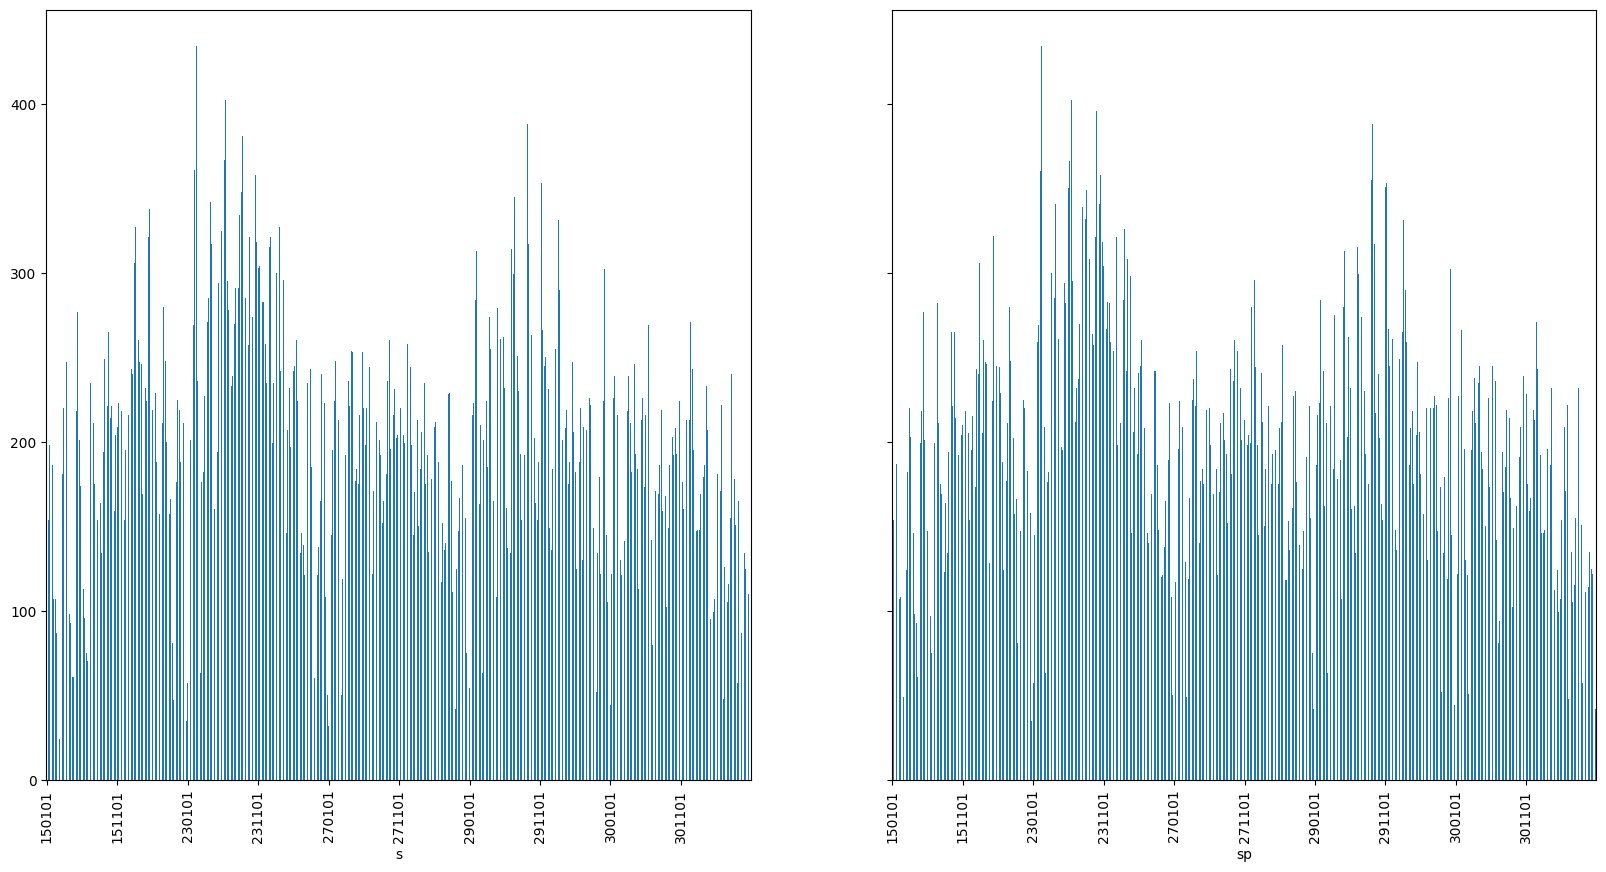

In [ ]:
# Range of states s, sp visited
# Plot number of visits vs. state s, sp
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
unique_s = large_data['s'].unique()
unique_sp = large_data['sp'].unique()

# Set of s, sp states are the same. 500 unique visited states.
# set(unique_s) == set(unique_sp)

for i, col in enumerate(['s', 'sp']):
    large_data[col].value_counts().sort_index().plot.bar(ax=axes[i])
    axes[i].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))

# ax = large_data['s'].value_counts().sort_index().plot.bar()
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# fig.savefig("large_states_visited.png", dpi=300)

Action 5 has mode: 0
Action 6 has mode: 0
Action 7 has mode: 0
Action 8 has mode: 0
Action 9 has mode: 0


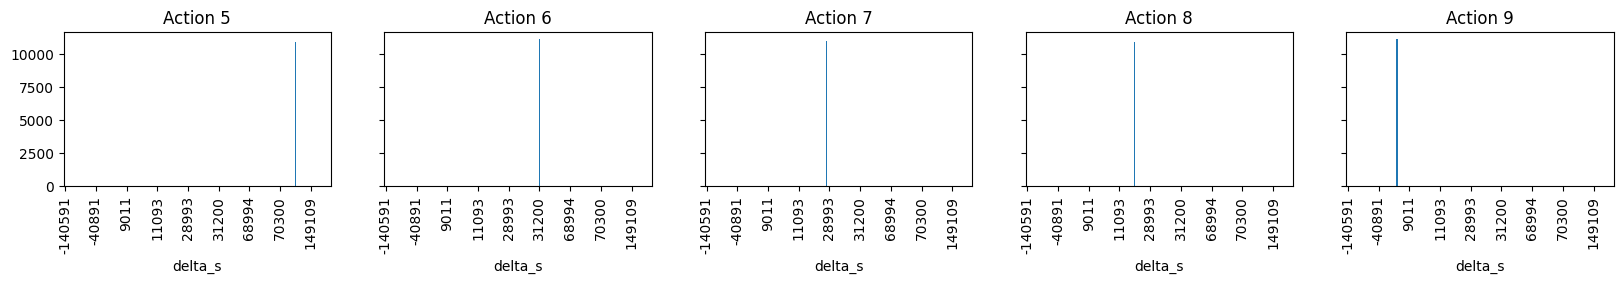

In [155]:
# Check actions
# large_data['delta_s'] = large_data['sp'] - large_data['s']
np.sort(large_data['delta_s'].unique())

action_delta_s = large_data[['a', 'delta_s']].value_counts().sort_index(level=0)
# action_delta_s[action_delta_s['a'] == 1]

fig, axes = plt.subplots(1, 5, figsize=(20, 2), sharex=True, sharey=True)
for i in range(5):
    action_delta_s.xs(i+5, level='a').sort_index().plot.bar(ax=axes[i])
    axes[i].set_title(f"Action {i+5}")
    axes[i].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    print(f"Action {i+5} has mode: {action_delta_s.xs(i+5, level='a').idxmax()}")
# Actions 1-4 are predictable, but actions 5-9 are usually 0 but sometimes random

# fig.savefig("large_action56789_probs.png", dpi=300)

In [157]:
action_delta_s.xs(i+5, level='a').idxmax()
# action_delta_s.xs(i+5, level='a').unique()

np.int64(0)

Large Data Observations

Rewards
- Only 7 unique values: [-10  -5   0   5  10  50 100]
- r=100 only at states sp = 301013, 301111, via actions [1,4]
- sp = 301013
    - s=301012, a=1 (delta_s = +1)
    - s=301014, a=2 (delta_s = -1)
    - s=301113, a=3 (delta_s = -100)
    - s=300413, a=4 (delta_s = +600)
- sp = 301111
    - s=301110, a=1 (delta_s = +1)
    - s=301112, a=2 (delta_s = -1)
    - s=301211, a=3 (delta_s = -100)
    - s=301011, a=4 (delta_s = +100)


Actions
- a = [1,4] are probabilistic
- a = [5,9] are random
    ```

### Approach


Use Q-learning or SARSA (whichever simpler to implement) to find action-value function $Q(s, a)$.
- Run through data multiple times to update $Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma Q(s', a') - Q(s, a))$

### SARSA (from Medium)

In [ ]:
Q = np.zeros((n_states + 1, n_actions + 1))

In [119]:
def sarsa(Q, data, iters=1, learning_rate=0.5, discount_rate=0.95):
    for it in range(iters):
        for i in range(len(data)-1):
            s, a, r, sp, _ = data.iloc[i]
            sp, ap, rp, spp, _ = data.iloc[i+1]
            Q[s, a] += learning_rate * (r + discount_rate * Q[sp, ap] - Q[s, a])
    return Q

In [120]:
def grid_display(data, xdim, ydim, fig_title=None):
    # data = data[1:, 1:].reshape((xdim, ydim, zdim))

    fig, axes = plt.subplots(1, figsize=(20, 15), sharex=True, sharey=True)

    # # Maximum, minimum value range for colorbar
    # vmin, vmax = data.min(), data.max()

    # for i in range(7):
    #     img = axes[i].imshow(data[:, :, i], cmap='viridis', vmin=vmin, vmax=vmax)
    #     axes[i].set_title(f"Action {i+1}")

    

    # plt.tight_layout()
    
    img = axes.matshow(data[1:, 1:].reshape(xdim, ydim))#, cmap='viridis', vmin=0, vmax=1)
    # plt.colorbar()
    # plt.colorbar(img, ax=axes, fraction=0.046, pad=0.04, shrink=0.8)
    cbar = fig.colorbar(img, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)

    if fig_title is not None:
        plt.savefig(f"{fig_title}.png", dpi=300)

In [121]:
Q = sarsa(Q, large_data, iters=100)
print(Q)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.79297988 3.46078454 ... 1.4892903  2.02051247 0.        ]]


In [ ]:
# np.save("large_Q_function_sarsa_100iters.npy", Q)
# loaded_arr = np.load("large_Q_function_sarsa_100iters.npy")

array([302021, 302021, 302021, 302021, 302021, 302021, 302021, 302021,
       302021, 302021])

### Extract Policy from Q Function

In [167]:
# Extract optimal policy pi(s) = a from action-value function Q(s, a)

def extract_policy(Q, mode='random'):
    """
    Limit only to actions 1-4.
    """
    policy = np.zeros(n_states+1)
    # predicable_action = np.random.randint(1, n_actions+1)
    predicable_action = 4
    for s in range(1, n_states+1):
        policy[s] = np.argmax(Q[s, :])
        if policy[s] not in [1, 2, 3, 4]: # Actions [5,9] are usually 0, random
            if mode == 'random':
                policy[s] = np.random.randint(1, 5)
            if mode == 'previous':
                policy[s] = predicable_action
        else:
            predicable_action = policy[s]

    return policy

In [168]:
optimal_policy_sarsa = extract_policy(Q, mode='random')

In [169]:
np.unique(optimal_policy_sarsa, return_counts=True)
# Why does sarsa return so many action 9's with previous?
# Likely because of using the previous best action. Limit to only actions 1 through 4.

(array([0., 1., 2., 3., 4.]), array([    1, 75557, 75667, 75593, 75203]))

In [170]:
# Write optimal policy to file
with open("large.policy", "w") as file:
    for a in optimal_policy_sarsa[1:]:
        file.write(f"{int(a)}\n")

### Future Improvements

- Average values of Q(s, a) with some distance-dependent discount for unvisited states s